# Colombian Newspaper analyis: A network science analysis

This report aims to analyze a Colombian newspaper news through network science. We conduct a textual analysis of approximately 90 articles, equally distributed among the topics of politics, education, and technology. By using co-occurrence networks, we map out conceptual associations within the articles to visually represent the typical connections made by the newspaper’s journalists. This approach allows us to illustrate El Tiempo’s editorial slant through graphical representations of the networked concepts.

The data was gathered manually from news sources in 2024. We'll try to draw conclusions about the news and potential biases, but there are limitations. These include the limited timeframe, small sample size, and subjective exclusion of certain words. So, the findings may not perfectly reflect reality. Still, we expect this analysis to help identify the main topics and biases in this Colombian newspaper.

#### Dataset
You can find the dataset at[/term_project/data/articles](/term_project/data/articles ) It contains a collection of articles. Here's an example sample:

```json
{
    "title": "Cookies: en que momento es recomendable no aceptarlas? Le contamos",
    "url": "https://www.eltiempo.com/tecnosfera/dispositivos/cookies-en-que-momento-es-recomendable-no-aceptarlas-le-contamos-3336305",
    "category": "tech",
    "content": [
      "Las cookies son fragmentos de texto que los sitios web envian a los navegadores con el fin de recordar la informacion de sus busquedas, lo que le facilita encontrar informacion de su idioma, almacena los articulos que ha anadido a su carrito de compras, entre otros datos.",
}
```

#### Packages

* Data handling
  * Pandas
* Text Processing
  * NLTK
  * Spacy
  * Regex (re)
* Network Analysis
  * Networkx

#### Installation instructions

1) pipenv install
2) pipenv run python -m spacy download es_core_news_lg

# Setup the project


In [2]:
import spacy
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
import re
from unidecode import unidecode
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from data.stop_words import STOP_WORDS

# Load the medium-sized Spanish model
nlp = spacy.load('es_core_news_lg')
# Download NLTK stop words 
nltk.download('stopwords')
# Get stop words for Spanish
spanish_stop_words = stopwords.words('spanish')
spanish_stop_words.extend(STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the data

In [9]:
def load_json_from_path(file_path:str):
    """
    Load JSON data from a file path.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The JSON data loaded from the file.
    """
    with open(file_path, 'r', encoding="utf8") as file:
        json_data = json.load(file)
    return json_data

In [10]:
articles = load_json_from_path('./data/articles.json')

In [11]:
f'There are {len(articles)} articles'

'There are 54 articles'

In [12]:
articles[0]

{'title': 'Petro y la lucha de clases / Columna de Felipe López Caballero',
 'url': 'https://www.eltiempo.com/politica/gobierno/petro-y-la-lucha-de-clases-columna-de-felipe-lopez-caballero-3333631',
 'category': 'politic',
 'content': ['La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  '2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  '3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores intern

# Data cleaning

* **Removing Special Characters**: Characters such as (%,$,#, etc.) do not provide any useful information, so they will be ignored
* **Remove stop words**:  Stop words are common words in a language that are often used to connect sentences or fill gaps in speech, such as  (el,ella, eso,aqui, alla, etc) even These words do not carry significant meaning on their own and are unlikely to contribute to the analysis of the text
* **Apply lemmatization**: Lemmatization is a process where words are reduced to their base or root form. This is particularly useful because some words may have different forms but convey the same concept. For instance, words like (cambio, cambia, cambiará, cambió, cambiaron, etc.) all stem from the same root word, "cambiar" (to change). By lemmatizing these words, we can simplify the data and ensure consistency in representing concepts, leading to more accurate analysis results.



In [13]:
import re
from unidecode import unidecode

def preprocess_text(text):
    
    text = unidecode(text) # Remove accents 
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) # Remove punctuation and convert to lowercase

    return text

def remove_stop_words(text, custom_stop_words):
    """
    Remove custom stop words from the input text.

    Args:
        text (str): Input text.
        custom_stop_words (list): List of custom stop words to be removed.

    Returns:
        str: Text with custom stop words removed.
    """
    stop_words = set(custom_stop_words)
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def lemmatize(text):
    # Process the text
    doc = nlp(text)
    # Extract the lemma for each token in the text
    lemmas = [token.lemma_ for token in doc]
    return lemmas

* Extract paragraphs from articles and unify them into a single list.

In [14]:
categories = [doc['category'] for doc in articles for para in doc['content']]

In [15]:
documents = [para for doc in articles for para in doc['content']]

In [16]:
len(categories), len(documents)

(685, 685)

In [17]:
list(zip(documents[0:5],categories[0:5]))

[('La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  'politic'),
 ('2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  'politic'),
 ('3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'politic'),
 ('Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores internacionales, pero la otra mitad tiene nombre propio. El problema es que Petro, un agitador político brillante, ha resultado un administrador incompetente con una personalidad paranoica y pendenc

* Apply cleaning

In [18]:
documents_clean = [remove_stop_words(preprocess_text(' '.join(lemmatize(d))),spanish_stop_words) for d in documents]

* Data after cleaning

In [19]:
documents_clean[0:3]

['explicacion narrativa petro red social crear colombia gobernado elite corrupto interesado enriquecer perpetuar',
 'petro presidente izquierda preocupacion pobre justicia social',
 'dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio']

In [20]:
def text_to_network(words: list[str]):
    network_dictionary = []
    limit = len(words) - 3
    for idx, word in enumerate(words):
        if idx == limit:
            break
        network_dictionary.extend(
            [
                {"_from": word, "to": words[idx + 1], "weight": 3},
                {"_from": word, "to": words[idx + 2], "weight": 2},
                {"_from": word, "to": words[idx + 3], "weight": 1},
            ]
        )
    network_dictionary.extend([
        {"_from": words[-3], "to": words[-2], "weight": 3},
        {"_from": words[-3], "to": words[-1], "weight": 2},
        {"_from": words[-2], "to": words[-1], "weight": 3}
    ])
    return network_dictionary


In [21]:
network_dict_dataset = [] 
network_dict_dataset.extend([
    relation | {"category":category}
    for doc, category in zip(documents_clean, categories)
    if len(doc.split()) >= 5
    for relation in text_to_network(doc.split())
])
#network_dict_dataset = [relation for sentence in network_dict_dataset for relation in sentence]

In [22]:
network_df = pd.DataFrame(network_dict_dataset)

In [23]:
network_df.shape

(32730, 4)

In [24]:
score_network_df = network_df.groupby(['_from','to','category']).agg(score=('weight', 'sum')).reset_index()

In [25]:
score_network_df.shape

(30216, 4)

In [26]:
len(score_network_df['_from'].value_counts())

3607

In [27]:
total_scores = score_network_df.groupby('category')['score'].transform('sum')
score_network_df['normalized_score'] = score_network_df['score'] / total_scores
score_network_df.sort_values('score', ascending=False).head(10)

,_from,to,category,score,normalized_score
24531,red,social,tech,57,0.001455
28944,universidad,nacional,education,54,0.004114
15484,inteligencia,artificial,tech,42,0.001072
13783,gustavo,petro,politic,36,0.002494
9712,educacion,superior,education,33,0.002514
24449,rector,universidad,education,33,0.002514
18418,ministerio,educacion,education,33,0.002514
16010,ismael,pena,education,30,0.002286
26750,sistema,operativo,tech,30,0.000766
8370,designacion,rector,education,29,0.002209


In [28]:
len(score_network_df)

30216

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

score_network_df['normalized_score'] = scaler.fit_transform(score_network_df[['normalized_score']])

In [30]:
score_network_df = score_network_df[score_network_df['_from'] != score_network_df['to'] ]

In [31]:
score_network_df.to_csv('data/newspaper_network.csv',index=False)

In [32]:
len(score_network_df)

30139

<Axes: ylabel='Frequency'>

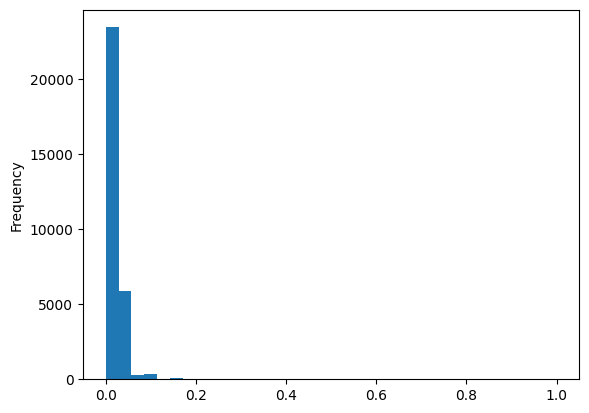

In [33]:
score_network_df.normalized_score.plot.hist(bins=35)

In [28]:
#score_network_df[score_network_df['_from']=='ver']

,_from,to,score


In [34]:
score_network_df['_from'].value_counts().head(5)

_from
usuario       168
aplicacion    148
nuevo         138
modelo        136
persona       135
Name: count, dtype: int64

In [35]:
import numpy as np

def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [37]:
score_network_df[score_network_df['_from']=='petro'].sort_values('normalized_score', ascending=False).head(20)

,_from,to,category,score,normalized_score
21757,petro,manifestar,politic,8,0.129341
21769,petro,presidente,politic,8,0.129341
21748,petro,frente,politic,5,0.078497
21754,petro,izquierda,politic,4,0.061550
21760,petro,ocurrir,politic,4,0.061550
21723,petro,asesinato,politic,4,0.061550
21776,petro,red,politic,3,0.044602
21718,petro,agitador,politic,3,0.044602
21758,petro,mesa,politic,3,0.044602
21746,petro,exguerrillero,politic,3,0.044602


In [54]:
#conx = score_network_df[score_network_df['_from']=='petro']['to']
#score_network_df[score_network_df['_from'].isin(conx)]
conx

,_from,to,category,score,normalized_score
35,abrir,aplicacion,tech,2,0.006242
36,abrir,cajon,tech,2,0.006242
37,abrir,cerrar,tech,3,0.012484
38,abrir,chat,tech,2,0.006242
39,abrir,comprension,tech,1,0.000000
...,...,...,...,...,...
28632,trino,ministerio,politic,3,0.044602
28633,trino,petro,politic,1,0.010706
28634,trino,presidente,politic,3,0.044602
28635,trino,publicacion,politic,1,0.010706


,_from,to,category,score,normalized_score
35,abrir,aplicacion,tech,2,0.006242
36,abrir,cajon,tech,2,0.006242
37,abrir,cerrar,tech,3,0.012484
38,abrir,chat,tech,2,0.006242
39,abrir,comprension,tech,1,0.000000
...,...,...,...,...,...
28634,trino,presidente,politic,3,0.044602
28635,trino,publicacion,politic,1,0.010706
28636,trino,validez,politic,2,0.027654
29318,vasquez,petro,politic,1,0.010706


In [ ]:
#score_network_df['to']=='petro')

In [95]:
filtering

0        False
1        False
2        False
3        False
4        False
         ...  
30211    False
30212    False
30213    False
30214    False
30215    False
Length: 30139, dtype: bool

In [98]:
score_network_df[filtering]

,_from,to,category,score,normalized_score


c:\Users\user\.virtualenvs\network_science-J3mh9D9T\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


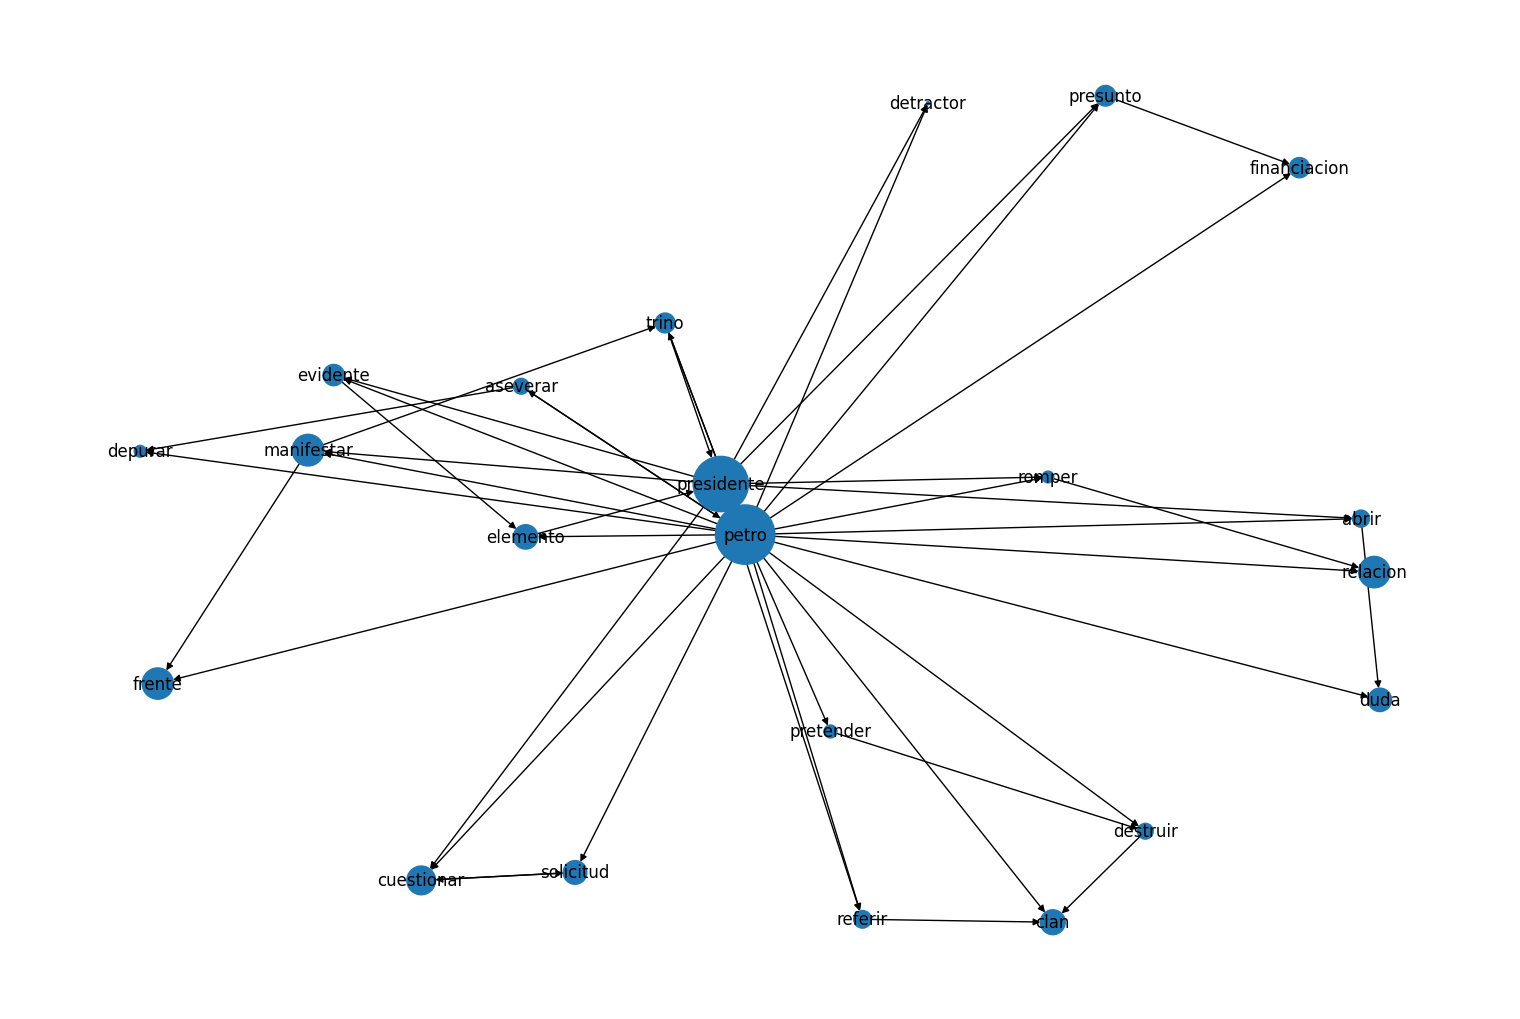

In [139]:
from networkx.algorithms.community import greedy_modularity_communities

G = nx.DiGraph()


# Add edges from the DataFrame with weights
for _, row in score_network_df.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

G = nx.ego_graph(G, "petro", radius=2)

nodes_to_include = []

# Iterate over the neighbors of "petro"
for neighbor in G.neighbors("petro"):
    # Check if the weight of the edge between "petro" and the neighbor is greater than 0.8
    if G["petro"][neighbor]["weight"] > 0.11:
        # Add the neighbor to the list of nodes to include
        nodes_to_include.append(neighbor)
        for x2 in G.neighbors(neighbor):
            if G[neighbor][x2]["weight"] > 0.45:
                nodes_to_include.extend(G.neighbors(x2))

# Include "petro" in the list of nodes to include
nodes_to_include.append("petro")

# Create the subgraph containing the nodes to include
G = G.subgraph(nodes_to_include)



# Calculate the sum of scores for each node
node_scores = score_network_df.groupby(['_from'])['normalized_score'].sum().reset_index()

# Create a dictionary where keys are nodes and values are their corresponding scores
node_scores_dict = dict(zip(node_scores['_from'], node_scores['normalized_score']))


subgraph = G

# Calculate the sum of scores for nodes in the subgraph
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Define node sizes based on the sum of scores for nodes in the subgraph
node_sizes = [(subgraph_node_scores[node]) * 800+5 for node in subgraph.nodes()]

# Create a list of node colors based on their communities

# Plot the subgraph with nodes sized proportionally to the sum of scores for each node
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(subgraph,k=0.2)


nx.draw(subgraph, pos, node_size=node_sizes,  cmap=plt.cm.Set3, with_labels=True)

plt.show()


In [155]:
from networkx.algorithms.community import greedy_modularity_communities

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in score_network_df.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Run the Louvain community detection algorithm
partition = greedy_modularity_communities(G, best_n=2)

# Create a dictionary where keys are community IDs and values are lists of nodes in that community
communities = {}
for idx, comm in enumerate(partition):
    for node in comm:
        communities[node] = idx

# Calculate the sum of scores for each node
node_scores = score_network_df.groupby(['_from'])['normalized_score'].sum().reset_index()

# Create a dictionary where keys are nodes and values are their corresponding scores
node_scores_dict = dict(zip(node_scores['_from'], node_scores['normalized_score']))

# Filter nodes based on the condition provided
#subgraph_filter1 = [node for node, community_id in communities.items() if community_id in [0,1,2] ]
subgraph_filter2 = [node for node, peso in node_scores_dict.items() if peso >=0.7]
#subgraph_nodes = list(set.intersection(set(subgraph_filter1),set(subgraph_filter2)))
subgraph = G.subgraph(subgraph_filter2)

# Calculate the sum of scores for nodes in the subgraph
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Define node sizes based on the sum of scores for nodes in the subgraph
node_sizes = [(subgraph_node_scores[node]) * 800+5 for node in subgraph.nodes()]

# Create a list of node colors based on their communities
node_colors = [communities[node] for node in subgraph.nodes()]



* Plots
- With no communities
- With communities
- With Categories
- Split by categories
- Degree distribution
* Metrics
- Global
- By Category


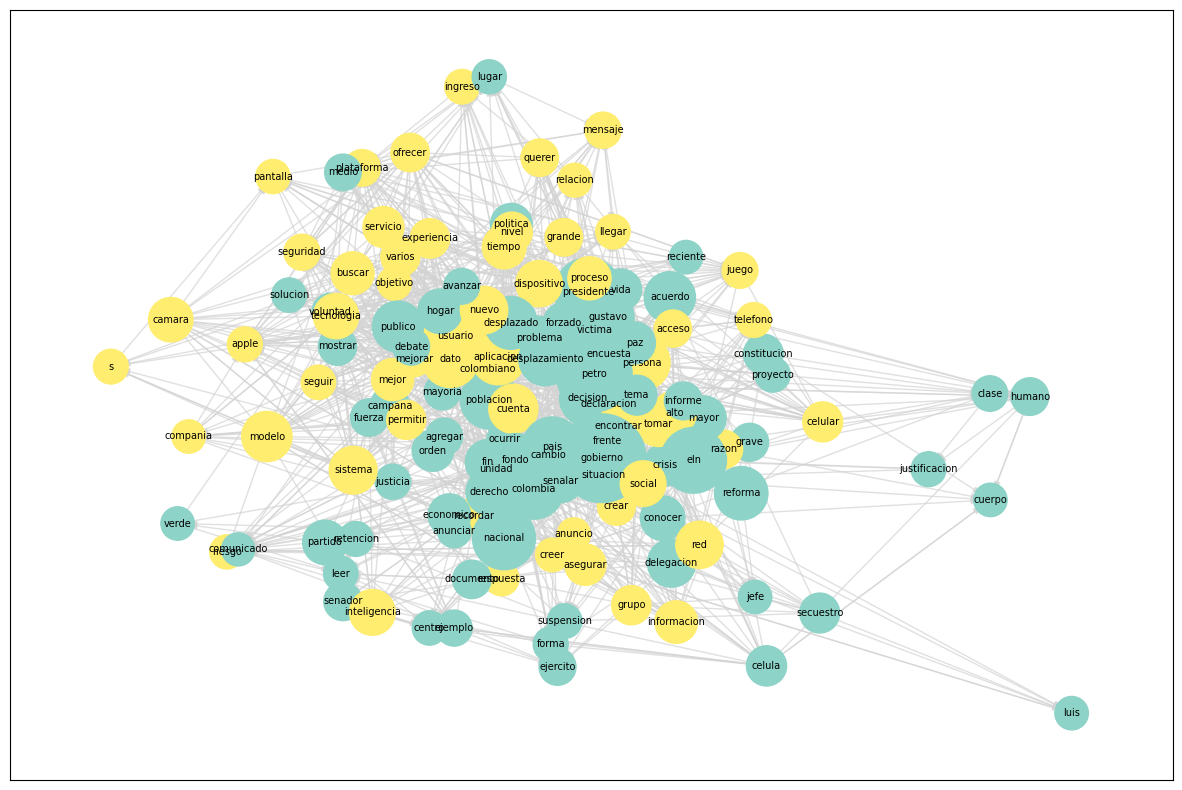

In [204]:
# Plot the subgraph with nodes sized proportionally to the sum of scores for each node
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(subgraph)

community_pos = {}
community_counts = {}
for node, community in zip(subgraph.nodes(),node_colors):
    if community in community_pos:
        community_pos[community] += np.array(pos[node])
        community_counts[community] += 1
    else:
        community_pos[community] = np.array(pos[node])
        community_counts[community] = 1

# Average the positions to find the center
for community in community_pos:
    community_pos[community] /= community_counts[community]

center = community_pos[0]+community_pos[1]#+community_pos[2]

rc = 0
community_pos[0] += rc*normalize(community_pos[0]- center)
community_pos[1] += rc*normalize(community_pos[1]- center)
#community_pos[2] += rc*normalize(community_pos[2]- center)

# Refine node positions to gravitate towards their community center
for node in pos:
    community = communities[node]
    pos[node] = 1 * np.array(pos[node]) + 0.2 * community_pos[community]
#pos = nx.spring_layout(subgraph, pos=pos,iterations=5)
#nx.draw_networkx_edges(subgraph, pos, alpha=0.3, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set3)

# Draw edges with adjusted transparency
nx.draw_networkx_edges(subgraph, pos, alpha=0.7, edge_color='lightgray')

# Draw labels
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.show()


In [168]:
degree_centrality = nx.degree_centrality(G)

In [169]:
closeness_centrality = nx.closeness_centrality(G)

In [171]:
betweenness_centrality = nx.betweenness_centrality(G)

In [173]:
eigenvector_centrality = nx.eigenvector_centrality(G)

In [174]:
pagerank = nx.pagerank(G)

In [175]:
clustering_coefficient = nx.clustering(G)

In [177]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [180]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.004555
Closeness Centrality      0.248408
Betweenness Centrality    0.000787
Eigenvector Centrality    0.009392
PageRank                  0.000300
Clustering Coefficient    0.257058
dtype: float64

**Degree Centrality (0.004555):**

In the context of a co-occurrence network over a newspaper, degree centrality could indicate the frequency of terms or topics appearing together within articles. A low degree centrality suggests that terms or topics do not frequently co-occur, or that the newspaper covers a wide range of diverse topics without strong associations between them.

**Closeness Centrality (0.248408):**

Closeness centrality could reflect how interconnected the topics covered by the newspaper are. A high closeness centrality suggests that the topics discussed in the newspaper are closely related, with articles covering a wide range of topics but still interconnected through shared themes or subjects.

**Betweenness Centrality (0.000787):**

Betweenness centrality indicates the extent to which certain topics or terms act as bridges or intermediaries between other topics in the newspaper. A low betweenness centrality suggests that there are not many topics or terms that play a significant role in connecting different themes or subjects within the newspaper's content.

**Eigenvector Centrality (0.009392):**

Eigenvector centrality could represent the influence or importance of certain topics or terms within the newspaper's content. A low eigenvector centrality suggests that there are not many highly influential topics or terms that consistently appear together within articles.

**PageRank (0.000300):**

PageRank measures the importance of topics or terms based on their connections to other important topics or terms within the newspaper's content. A low PageRank value indicates that there are not many topics or terms that are highly recommended or frequently referenced within articles.

**Clustering Coefficient (0.257058):**

In the context of a co-occurrence network over a newspaper, a high clustering coefficient suggests that there are clusters or groups of topics that are frequently discussed together within articles. This could indicate that the newspaper tends to cover certain themes or subjects in depth, with articles related to those themes often appearing together.

TODO
* Add documentation
* Generalize communities
* Add metrics general  and by category

In [190]:
network_metrics.nlargest(5, 'Degree Centrality')['Node']

121        usuario
25      aplicacion
2      dispositivo
292         modelo
107           dato
Name: Node, dtype: object

In [203]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,usuario,0.100361,usuario,0.377353,usuario,0.067267,usuario,0.208518,gobierno,0.005322,autorizado,1.000000
1,aplicacion,0.080529,aplicacion,0.370715,aplicacion,0.048879,aplicacion,0.183790,usuario,0.004669,delta,1.000000
2,dispositivo,0.070012,dispositivo,0.363138,dispositivo,0.041973,dispositivo,0.163673,petro,0.003894,monitorear,1.000000
3,modelo,0.062500,nuevo,0.357321,modelo,0.033223,nuevo,0.137180,aplicacion,0.003501,pronto,1.000000
4,dato,0.059796,dato,0.352295,dato,0.031755,plataforma,0.134345,dispositivo,0.003308,socialismo,0.900000
5,tecnologia,0.058293,plataforma,0.351121,tecnologia,0.030562,experiencia,0.121732,pais,0.003206,transicion,0.846154
6,nuevo,0.055589,experiencia,0.349395,persona,0.029177,dato,0.119762,colombia,0.003194,centralizado,0.833333
7,persona,0.054688,modelo,0.348558,nuevo,0.028071,ofrecer,0.107569,social,0.002942,delantero,0.800000
8,cuenta,0.048978,red,0.348121,gobierno,0.025135,servicio,0.106866,persona,0.002898,organica,0.769231
9,gobierno,0.048978,tecnologia,0.347132,colombia,0.023237,celular,0.104429,presidente,0.002694,hepatitis,0.750000


In [192]:
top_nodes_by_metric = pd.DataFrame({
    f'{metric}': [node for node in network_metrics.nlargest(5, metric)['Node']] 
    for metric in network_metrics.columns[1:]
})
top_nodes_by_metric

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,PageRank,Clustering Coefficient
0,usuario,usuario,usuario,usuario,gobierno,autorizado
1,aplicacion,aplicacion,aplicacion,aplicacion,usuario,delta
2,dispositivo,dispositivo,dispositivo,dispositivo,petro,monitorear
3,modelo,nuevo,modelo,nuevo,aplicacion,pronto
4,dato,dato,dato,plataforma,dispositivo,socialismo


In [183]:
network_metrics.nlargest(5, 'Degree Centrality')[['Node','Degree Centrality']]

,Node,Degree Centrality
121,usuario,0.100361
25,aplicacion,0.080529
2,dispositivo,0.070012
292,modelo,0.062500
107,dato,0.059796


In [185]:
network_metrics.nlargest(5, 'Closeness Centrality')[['Node','Closeness Centrality']]

,Node,Closeness Centrality
121,usuario,0.377353
25,aplicacion,0.370715
2,dispositivo,0.363138
34,nuevo,0.357321
107,dato,0.352295


In [186]:
network_metrics.nlargest(5,'Betweenness Centrality')[['Node','Betweenness Centrality']]

,Node,Betweenness Centrality
121,usuario,0.067267
25,aplicacion,0.048879
2,dispositivo,0.041973
292,modelo,0.033223
107,dato,0.031755


In [ ]:
network_metrics.nlargest(5,'Betweenness Centrality')[['Node','Betweenness Centrality']]

In [ ]:
'Closeness Centrality'
'Betweenness Centrality'
'Eigenvector Centrality'
'PageRank'
'Clustering Coefficient'

In [200]:
from pyvis.network import Network

# Calculate degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Create a Pyvis network instance
#notebook=True
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", select_menu=True)

# Add nodes from the NetworkX graph G
for node, centrality in degree_centrality.items():
    net.add_node(node, size=centrality*100, color='skyblue')

# Add edges from the NetworkX graph G
for edge in G.edges():
    source, target = edge
    net.add_edge(source, target, title=f'{source}->{target}')

# Set options for the network
net.repulsion()

# Display the network inside the notebook
net.show("network_plot.html", notebook=False)


network_plot.html


# Modeling

Create a Count Vectorizer for create a word dictionary

In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words=spanish_stop_words)

# Fit and transform the documents
X = vectorizer.fit_transform(documents)


In [15]:
vectorizer.get_feature_names_out()[0:5]

array(['abrir', 'abstracto', 'acabar', 'acertado', 'aclarar'],
      dtype=object)

In [16]:
def generate_ngrams(text, n):
    words = text.split()
    ngrams = []
    step = n-1
    for i in range(0,len(words) - n + 1,1):
        ngrams.append(' '.join(words[i:i + n]))
    return ngrams

## Analyzing Contextual Word Relationships Using a Two-Word Window

* Create word pair relationships

In [18]:
docs_pairs = []

# Generate pairs after removing stop words for each document
docs_pairs.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),2)])

print(docs_pairs[0:3])

['explicacion narrativa', 'narrativa petro', 'petro red']


In [19]:
encoding = vectorizer.transform(docs_pairs).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [20]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            32
presidente       17
constitucion     14
gobierno         12
deber            12
campana          11
constituyente    10
gustavo          10
colombia         10
razon             9
izquierda         8
dtype: int64

In [21]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,gobierno,deber,campana,constituyente,gustavo,colombia,razon,izquierda
petro,0,0,0,0,0,1,0,5,0,1,0
presidente,0,0,0,0,0,0,0,3,0,0,2
constitucion,0,0,0,0,2,0,0,0,0,0,0
gobierno,0,0,0,0,1,0,0,0,0,0,0
deber,0,0,2,1,0,0,1,0,0,0,0
campana,1,0,0,0,0,0,0,0,0,0,0
constituyente,0,0,0,0,1,0,0,0,0,0,0
gustavo,5,3,0,0,0,0,0,0,0,0,0
colombia,0,0,0,0,0,0,0,0,0,0,0
razon,1,0,0,0,0,0,0,0,0,0,0


In [36]:
encoder = dict(enumerate(co_ocurrences_df.index.tolist()))

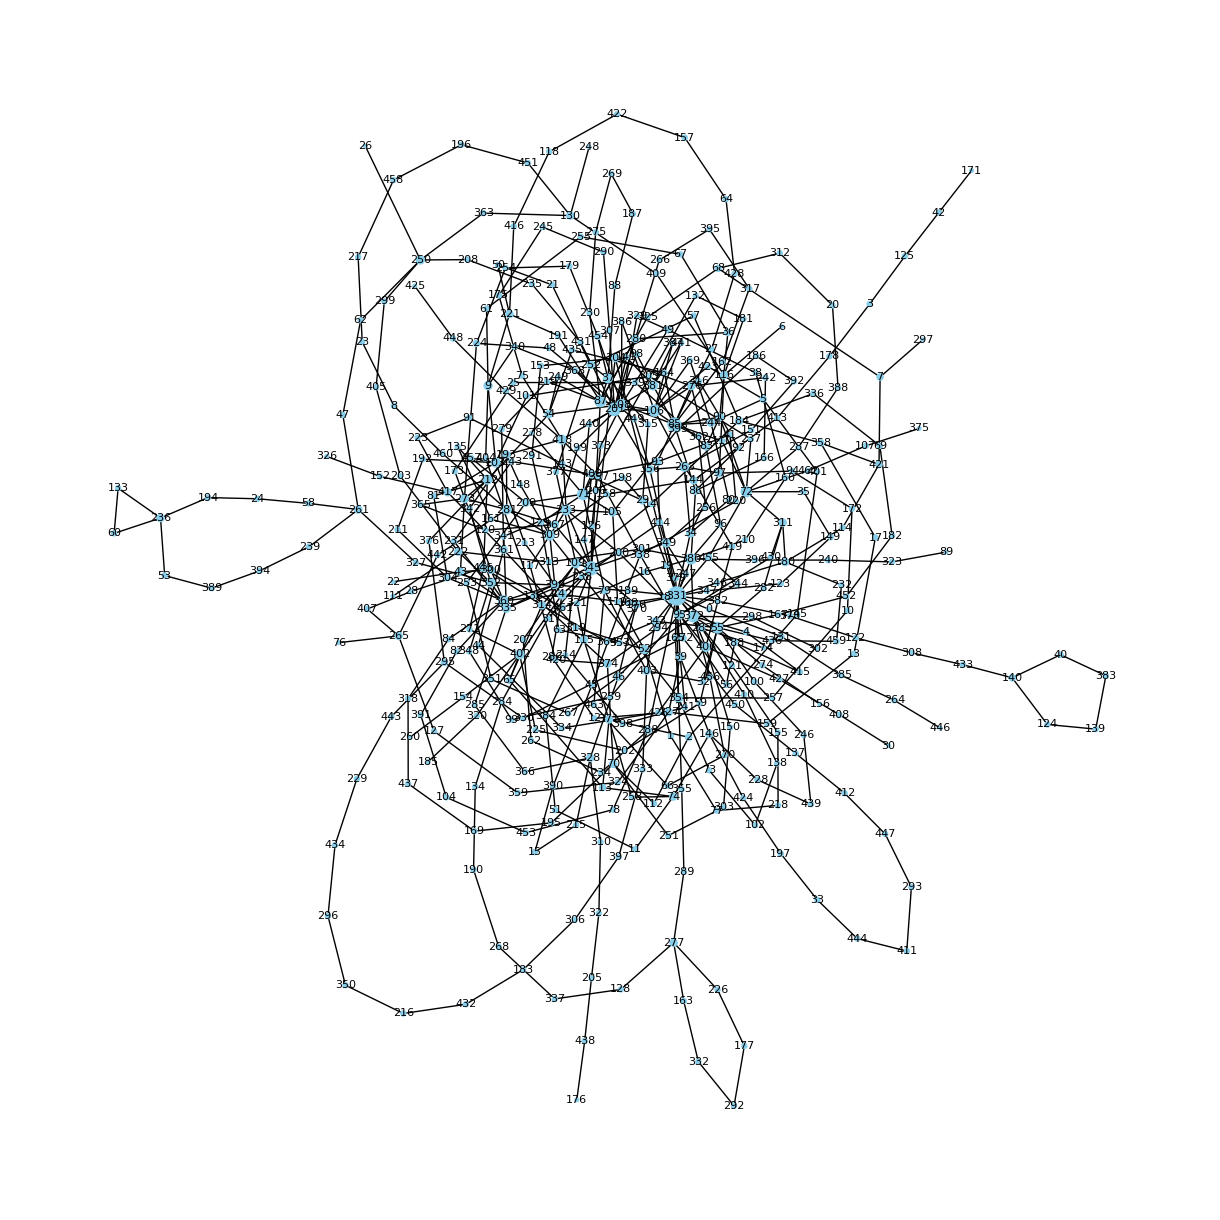

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming co_ocurrences_df is your adjacency matrix DataFrame
# Convert the DataFrame to a numpy array
adjacency_matrix = co_ocurrences_df.values

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Calculate degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Draw the graph
plt.figure(figsize=(12, 12))  # Adjust the figure size
pos = nx.kamada_kawai_layout(G)  # Use Kamada-Kawai layout for better organization
node_size = [v * 3000 for v in degree_centrality.values()]  # Adjust node size based on degree centrality
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=node_size, edge_color='black', linewidths=1, font_size=8)  # Adjust the font size

# Show plot
plt.show()


In [45]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:6]
[encoder[e] for e  in top_betweenness_nodes]


['petro', 'presidente', 'razon', 'elemento', 'gobierno', 'constitucion']

In [46]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Get the top 6 nodes by degree centrality
top_degree_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:6]
[encoder[e] for e  in top_degree_nodes]


['petro', 'constitucion', 'presidente', 'gobierno', 'deber', 'campana']

In [51]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Get the top 6 nodes by closeness centrality
top_closeness_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:6]
[encoder[e] for e  in top_closeness_nodes]


['petro', 'primero', 'presidente', 'gustavo', 'exguerrillero', 'reforma']

In [74]:
encoding = vectorizer.transform(docs_pairs).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

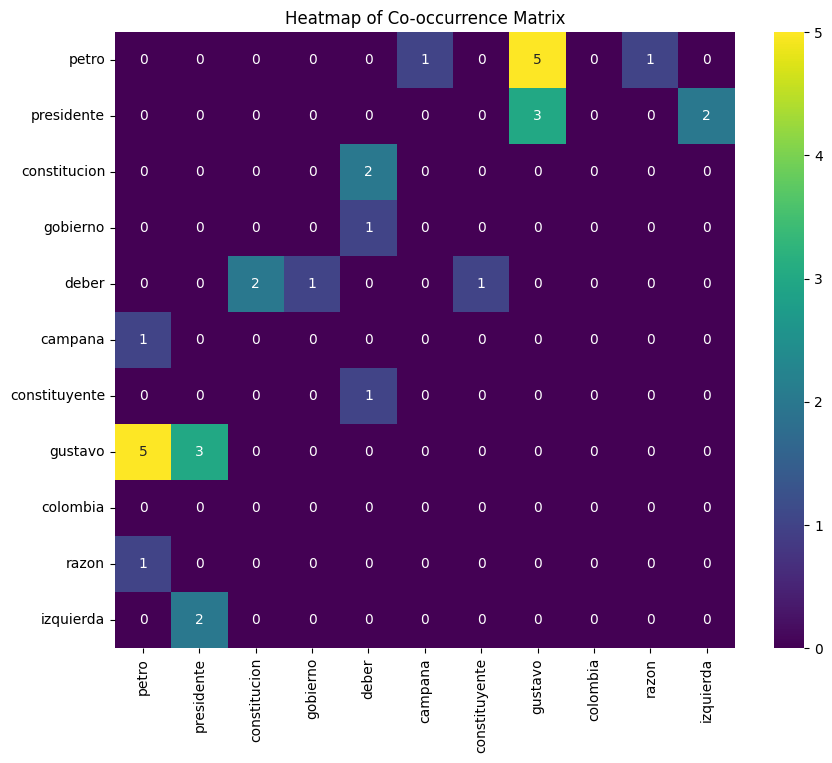

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'co_occurrences_df' is your DataFrame and 'top_matches' is a list or index slice defining the top matches.
# Filter the DataFrame to only include rows and columns from 'top_matches'
sub_matrix = co_ocurrences_df.loc[top_matches.index, top_matches.index]

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your specific needs
sns.heatmap(sub_matrix, annot=True, fmt="d", cmap='viridis')
plt.title('Heatmap of Co-occurrence Matrix')
plt.show()


## Analyzing Contextual Word Relationships Using a Three-Word Window

In [65]:
docs_group = []

# Generate pairs after removing stop words for each document
docs_group.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),3)])

print(docs_group[0:3])

['explicacion narrativa petro', 'narrativa petro red', 'petro red social']


* Calculating co-occurences

In [66]:
encoding = vectorizer.transform(docs_group).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [67]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            92
presidente       50
constitucion     42
deber            34
gobierno         34
campana          32
constituyente    30
gustavo          28
colombia         26
razon            26
pais             24
dtype: int64

In [68]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,deber,gobierno,campana,constituyente,gustavo,colombia,razon,pais
petro,0,5,0,0,0,3,0,9,0,3,0
presidente,5,0,0,0,0,0,1,6,0,0,0
constitucion,0,0,0,4,0,0,0,1,0,0,0
deber,0,0,4,0,2,0,2,0,0,0,0
gobierno,0,0,0,2,0,0,0,0,1,0,0
campana,3,0,0,0,0,0,0,0,0,0,0
constituyente,0,1,0,2,0,0,0,0,0,0,0
gustavo,9,6,1,0,0,0,0,0,0,0,0
colombia,0,0,0,0,1,0,0,0,0,0,0
razon,3,0,0,0,0,0,0,0,0,0,0


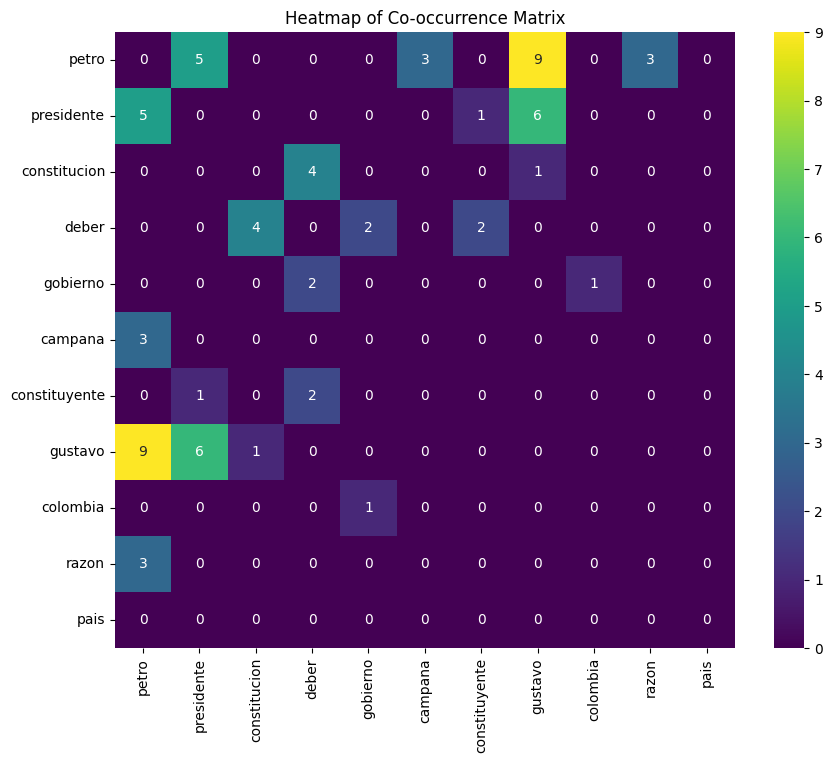

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'co_occurrences_df' is your DataFrame and 'top_matches' is a list or index slice defining the top matches.
# Filter the DataFrame to only include rows and columns from 'top_matches'
sub_matrix = co_ocurrences_df.loc[top_matches.index, top_matches.index]

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your specific needs
sns.heatmap(sub_matrix, annot=True, fmt="d", cmap='viridis')
plt.title('Heatmap of Co-occurrence Matrix')
plt.show()


## Analyzing Contextual Word Relationships Using a Five-Word Window

In [58]:
docs_group = []

# Generate pairs after removing stop words for each document
docs_group.extend([pair for d in documents for pair in generate_ngrams(remove_stop_words(d, spanish_stop_words),5)])

print(docs_group[0:3])

['explicacion narrativa petro red social', 'narrativa petro red social crear', 'petro red social crear segun']


In [59]:
encoding = vectorizer.transform(docs_group).toarray()
co_ocurrences = encoding.T@encoding

names = vectorizer.get_feature_names_out().tolist()

np.fill_diagonal(co_ocurrences, 0)

co_ocurrences_df = pd.DataFrame(co_ocurrences, index=names, columns=names)

In [60]:
top_matches = co_ocurrences_df.sum(axis=1).sort_values(ascending=False).head(11)
top_matches

petro            272
presidente       156
constitucion     140
deber            107
gobierno         100
constituyente     96
gustavo           88
pais              80
publico           80
campana           80
problema          80
dtype: int64

In [62]:
co_ocurrences_df.loc[top_matches.index,top_matches.index]

,petro,presidente,constitucion,deber,gobierno,constituyente,gustavo,pais,publico,campana,problema
petro,0,15,2,0,0,0,17,3,2,6,11
presidente,15,0,0,0,0,3,12,0,0,0,2
constitucion,2,0,0,9,3,1,3,0,0,0,0
deber,0,0,9,0,5,4,0,0,0,0,0
gobierno,0,0,3,5,0,0,0,0,0,0,0
constituyente,0,3,1,4,0,0,0,0,0,0,0
gustavo,17,12,3,0,0,0,0,2,1,0,0
pais,3,0,0,0,0,0,2,0,3,0,8
publico,2,0,0,0,0,0,1,3,0,0,2
campana,6,0,0,0,0,0,0,0,0,0,0


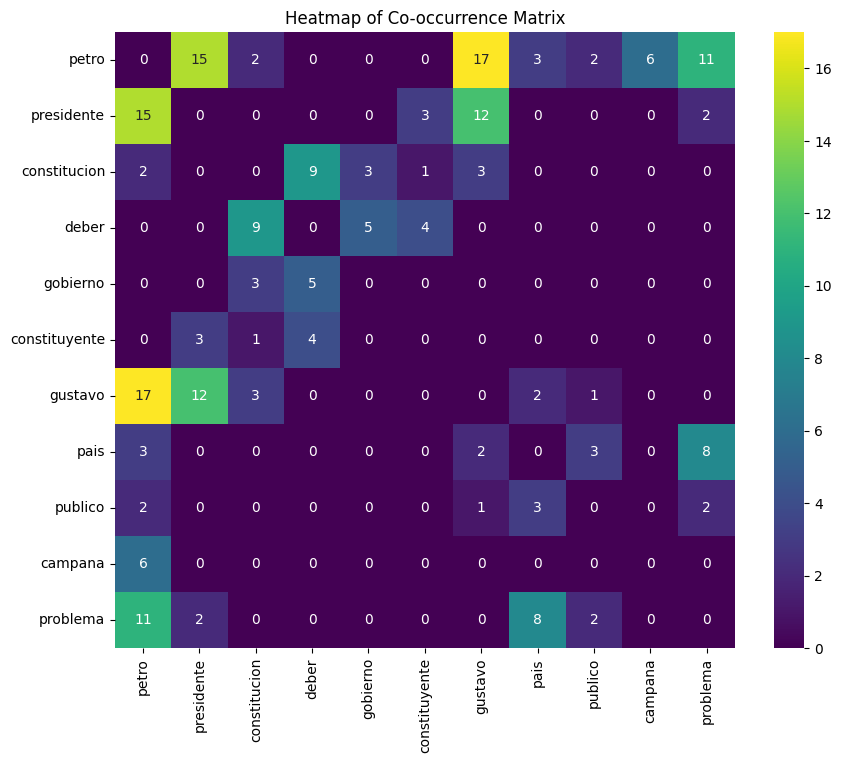

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'co_occurrences_df' is your DataFrame and 'top_matches' is a list or index slice defining the top matches.
# Filter the DataFrame to only include rows and columns from 'top_matches'
sub_matrix = co_ocurrences_df.loc[top_matches.index, top_matches.index]

# Create a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your specific needs
sns.heatmap(sub_matrix, annot=True, fmt="d", cmap='viridis')
plt.title('Heatmap of Co-occurrence Matrix')
plt.show()


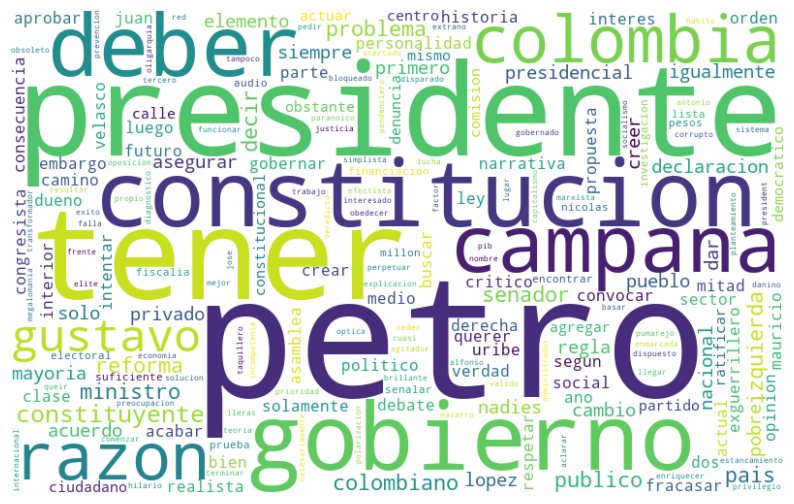

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Example raw text
raw_text = ' '.join(documents)

# Function to preprocess and compute word frequencies
def calculate_frequencies(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = text.split()
    # Calculate frequencies
    frequencies = Counter(words)
    return frequencies

# Calculate frequencies
word_frequencies = calculate_frequencies(raw_text)

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


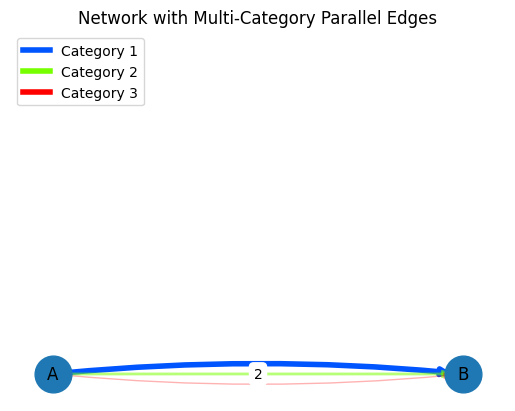

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Data including multiple categories for the same edge
data = [
    ('A', 'B', {'category': 1, 'weight': 5}),
    ('A', 'B', {'category': 2, 'weight': 3}),
    ('A', 'B', {'category': 3, 'weight': 2}),
]

# Create a directed graph
G = nx.MultiDiGraph()

# Add edges to the graph
for u, v, attr in data:
    G.add_edge(u, v, weight=attr['weight'], category=attr['category'])

# Define colors and styles for different categories
category_styles = {
    1: {"color": "#0055FF", "style": "solid", "label": 'Category 1'},
    2: {"color": "#77FF00", "style": "solid", "label": 'Category 2'},
    3: {"color": "#FF0000", "style": "solid", "label": 'Category 3'}
}

# Node positions
pos = {'A': (0, 0), 'B': (1, 0)}

# Drawing nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# Extract max and min weights for dynamic edge styling
max_weight = max(attr['weight'] for u, v, attr in data)
min_weight = min(attr['weight'] for u, v, attr in data)

# Function to scale values (linear interpolation)
def scale(value, min_val, max_val, new_min, new_max):
    return new_min + (new_max - new_min) * ((value - min_val) / (max_val - min_val))

# Set offsets for parallel edges to avoid overlapping
offsets = {1: -0.05, 2: 0, 3: 0.05}  # Adjust these offsets as needed

# Handle parallel edges
for u, v, key, data in G.edges(data=True, keys=True):
    # Set edge width and alpha dynamically
    width = scale(data['weight'], min_weight, max_weight, 1, 4)
    alpha = scale(data['weight'], min_weight, max_weight, 0.3, 1)
    nx.draw_networkx_edges(G, pos,
                           edgelist=[(u, v)],
                           connectionstyle=f'arc3,rad={offsets[data["category"]]}',
                           width=width,
                           edge_color=category_styles[data['category']]['color'],
                           style=category_styles[data['category']]['style'],
                           alpha=alpha,
                           label=category_styles[data['category']]['label'])

# Edge labels for weights
edge_labels = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

# Draw labels
nx.draw_networkx_labels(G, pos)

# Adding a legend
handles = [plt.Line2D([0], [0], color=style['color'], lw=4, linestyle=style['style'], label=style['label']) 
           for style in category_styles.values()]
plt.legend(handles=handles, loc='upper left')

plt.title('Network with Multi-Category Parallel Edges')
plt.axis('off')  # Turn off the axis
plt.show()
